<center><h1 style="font-size:3em"> COVID-19 in France </h1></center>

***Aim***: Analyze the OpenCOVID-19 French dataset published by the "Agences Regionales de Santé"

In [462]:
# Base packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Find coordinates
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="myapp2")
import time

# Plot static maps
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Plot interactive maps
import geopandas as gpd
from shapely import wkt
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, ColumnDataSource
import json
from bokeh.models import HoverTool

# I. Load the base CSV file

In [463]:
df = pd.read_csv("https://raw.githubusercontent.com/opencovid19-fr/data/master/dist/chiffres-cles.csv")
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,granularite,maille_code,maille_nom,cas_confirmes,deces,reanimation,source_nom,source_url,source_type
0,2020-01-24,departement,DEP-16,Charente,0.0,NaN,NaN,ARS Nouvelle-Aquitaine,https://www.nouvelle-aquitaine.ars.sante.fr/co...,agences-regionales-sante
1,2020-01-24,departement,DEP-17,Charente-Maritime,0.0,NaN,NaN,ARS Nouvelle-Aquitaine,https://www.nouvelle-aquitaine.ars.sante.fr/co...,agences-regionales-sante
2,2020-01-24,departement,DEP-19,Corrèze,0.0,NaN,NaN,ARS Nouvelle-Aquitaine,https://www.nouvelle-aquitaine.ars.sante.fr/co...,agences-regionales-sante
3,2020-01-24,departement,DEP-23,Creuse,0.0,NaN,NaN,ARS Nouvelle-Aquitaine,https://www.nouvelle-aquitaine.ars.sante.fr/co...,agences-regionales-sante
4,2020-01-24,departement,DEP-24,Dordogne,0.0,NaN,NaN,ARS Nouvelle-Aquitaine,https://www.nouvelle-aquitaine.ars.sante.fr/co...,agences-regionales-sante


! Reports are not made every day...
If there is no information, you need to fill with the previous value known.

In [464]:
df = df[['date', 'granularite', 'maille_code', 'maille_nom', 'cas_confirmes', 'deces', 'reanimation']]
df = df[df['granularite'] == 'departement']
df.head()

,date,granularite,maille_code,maille_nom,cas_confirmes,deces,reanimation
0,2020-01-24,departement,DEP-16,Charente,0.0,NaN,NaN
1,2020-01-24,departement,DEP-17,Charente-Maritime,0.0,NaN,NaN
2,2020-01-24,departement,DEP-19,Corrèze,0.0,NaN,NaN
3,2020-01-24,departement,DEP-23,Creuse,0.0,NaN,NaN
4,2020-01-24,departement,DEP-24,Dordogne,0.0,NaN,NaN


In [465]:
df

,date,granularite,maille_code,maille_nom,cas_confirmes,deces,reanimation
0,2020-01-24,departement,DEP-16,Charente,0.0,NaN,NaN
1,2020-01-24,departement,DEP-17,Charente-Maritime,0.0,NaN,NaN
2,2020-01-24,departement,DEP-19,Corrèze,0.0,NaN,NaN
3,2020-01-24,departement,DEP-23,Creuse,0.0,NaN,NaN
4,2020-01-24,departement,DEP-24,Dordogne,0.0,NaN,NaN
...,...,...,...,...,...,...,...
1945,2020-03-19,departement,DEP-84,Vaucluse,17.0,NaN,NaN
1946,2020-03-19,departement,DEP-86,Vienne,33.0,NaN,NaN
1947,2020-03-19,departement,DEP-87,Haute-Vienne,8.0,NaN,NaN
1948,2020-03-19,departement,DEP-971,Guadeloupe,45.0,NaN,3.0


In [466]:
date_time_str = '2020-01-24'
base = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')

date_list = [base + datetime.timedelta(days=x) for x in range(56)]

In [467]:
list_maille_code = np.unique(df['maille_code'])

In [468]:
for date in date_list:
    for dep in list_maille_code:
        if len(df[(df['date'] == date) & (df['maille_code'] == dep)]) == 0:
            if date == '2020-01-24':
                if list(df[(df['maille_code'] == dep) & (df['date'] == date)]['cas_confirmes']) == [] and list(df[(df['maille_code'] == dep) & (df['date'] == date)]['deces']) == [] and list(df[(df['maille_code'] == dep) & (df['date'] == date)]['reanimation']) == [] :
                    df = df.append({'date':date, 'granularite':'departement', 'maille_code': dep, 'maille_nom':list(df[df['maille_code'] == dep]['maille_nom'])[0], 'cas_confirmes':0, 'deces':0, 'reanimation':0}, ignore_index=True)
            else:
                yesterday = date - datetime.timedelta(days=1)
                if list(df[(df['maille_code'] == dep) & (df['date'] == yesterday)]['cas_confirmes']) == [] and list(df[(df['maille_code'] == dep) & (df['date'] == yesterday)]['deces']) == [] and list(df[(df['maille_code'] == dep) & (df['date'] == yesterday)]['reanimation']) == [] :
                    df = df.append({'date':date, 'granularite':'departement', 'maille_code': dep, 'maille_nom':list(df[df['maille_code'] == dep]['maille_nom'])[0], 'cas_confirmes':0, 'deces':0, 'reanimation':0}, ignore_index=True)
                else:
                    df = df.append({'date':date, 'granularite':'departement', 'maille_code': dep, 'maille_nom':list(df[df['maille_code'] == dep]['maille_nom'])[0], 'cas_confirmes':list(df[(df['maille_code'] == dep) & (df['date'] == yesterday)]['cas_confirmes'])[0], 'deces':list(df[(df['maille_code'] == dep) & (df['date'] == yesterday)]['deces'])[0], 'reanimation': list(df[(df['maille_code'] == dep) & (df['date'] == yesterday)]['reanimation'])[0]}, ignore_index=True)
            

In [469]:
df

,date,granularite,maille_code,maille_nom,cas_confirmes,deces,reanimation
0,2020-01-24,departement,DEP-16,Charente,0.0,NaN,NaN
1,2020-01-24,departement,DEP-17,Charente-Maritime,0.0,NaN,NaN
2,2020-01-24,departement,DEP-19,Corrèze,0.0,NaN,NaN
3,2020-01-24,departement,DEP-23,Creuse,0.0,NaN,NaN
4,2020-01-24,departement,DEP-24,Dordogne,0.0,NaN,NaN
...,...,...,...,...,...,...,...
5724,2020-03-19,departement,DEP-93,Seine-Saint-Denis,45.0,NaN,NaN
5725,2020-03-19,departement,DEP-94,Val-de-Marne,48.0,NaN,NaN
5726,2020-03-19,departement,DEP-95,Val-d'Oise,60.0,1.0,NaN
5727,2020-03-19,departement,DEP-972,Martinique,16.0,0.0,NaN


In [472]:
df[df['date'] == '2020-01-28']

,date,granularite,maille_code,maille_nom,cas_confirmes,deces,reanimation
1769,2020-01-28,departement,DEP-01,Ain,0.0,0.0,0.0
1770,2020-01-28,departement,DEP-02,Aisne,0.0,0.0,0.0
1771,2020-01-28,departement,DEP-03,Allier,0.0,0.0,0.0
1772,2020-01-28,departement,DEP-04,Alpes-de-Haute-Provence,0.0,0.0,0.0
1773,2020-01-28,departement,DEP-05,Hautes-Alpes,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1864,2020-01-28,departement,DEP-95,Val-d'Oise,0.0,0.0,0.0
1865,2020-01-28,departement,DEP-971,Guadeloupe,0.0,0.0,0.0
1866,2020-01-28,departement,DEP-972,Martinique,0.0,0.0,0.0
1867,2020-01-28,departement,DEP-973,Guyane,0.0,0.0,0.0


In [498]:
df['date'] 

56

In [476]:
df = df.sort_values(by=['date', 'maille_code'])

# II. Identify coordinates

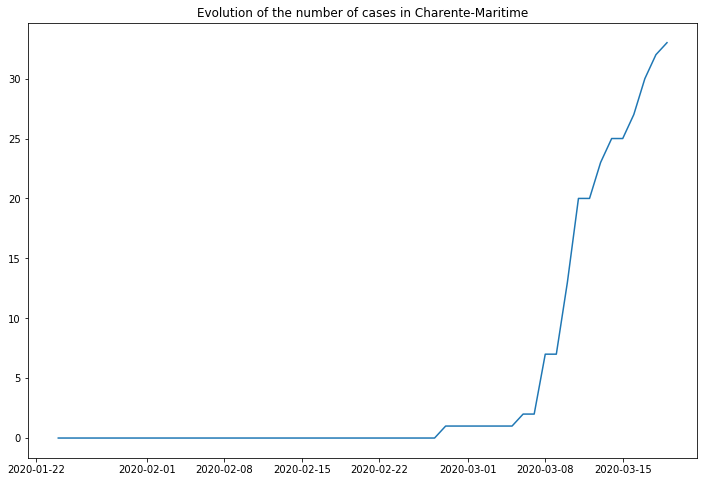

In [477]:
plt.figure(figsize=(12,8))
plt.plot(df[df['maille_code'] == 'DEP-17']['date'], df[df['maille_code'] == 'DEP-17']['cas_confirmes'])
plt.title("Evolution of the number of cases in " + str(np.unique(df[df['maille_code'] == 'DEP-17']['maille_nom'])[0]))
plt.show()

In [58]:
latitude = []
longitude = []

for line in np.unique(df['maille_nom']):
    location = geolocator.geocode(line)
    
    try:
        latitude.append(location.latitude)
        longitude.append(location.longitude)
        
    except:
        latitude.append(0)
        longitude.append(0)
        
    time.sleep(3)

In [62]:
dict_loc = {}

i = 0
for val in np.unique(df['maille_nom']):
    dict_loc[val] = [latitude[i], longitude[i]]
    
    i += 1

In [76]:
df2 = pd.DataFrame(dict_loc).transpose().reset_index()
df2.columns = ['Region', 'Latitude', 'Longitude']

In [80]:
# Fill in missing values manually
df2.loc[14]['Latitude'] = 43.5912
df2.loc[14]['Longitude'] = 5.3103

df2.loc[35]['Latitude'] = 48.4586
df2.loc[35]['Longitude'] = 2.1569

/Users/maelfabien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/maelfabien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [86]:
df2.to_csv('coordinates_region.csv')

# III. Data Exploration

In [478]:
df2 = pd.read_csv("coordinates_region.csv")

def find_lat(x):
    return float(df2[df2['Region'] == x]['Latitude'])

def find_long(x):
    return float(df2[df2['Region'] == x]['Longitude'])

df['latitude'] = df['maille_nom'].apply(lambda x: find_lat(x))
df['longitude'] = df['maille_nom'].apply(lambda x: find_long(x))

#df.to_csv('full_dataframe.csv')

In [479]:
MAX_LONGITUDE = 10
MIN_LONGITUDE = -5
MIN_LATITUDE = 35

# Zoom on continental France
df_france = df[(df['longitude'] < MAX_LONGITUDE) & (df['longitude'] > MIN_LONGITUDE) & (df['latitude']>MIN_LATITUDE)]

## 1. Simple plots using matplotlib

In [480]:
df_dep = df_france[df_france['granularite'] == "departement"]
df_dep = df_dep.fillna(0)
df_dep.head()

,date,granularite,maille_code,maille_nom,cas_confirmes,deces,reanimation,latitude,longitude
1382,2020-01-24,departement,DEP-01,Ain,0.0,0.0,0.0,49.453285,3.606899
1383,2020-01-24,departement,DEP-02,Aisne,0.0,0.0,0.0,49.453285,3.606899
1384,2020-01-24,departement,DEP-03,Allier,0.0,0.0,0.0,46.367464,3.163883
1385,2020-01-24,departement,DEP-04,Alpes-de-Haute-Provence,0.0,0.0,0.0,44.164083,6.187852
1386,2020-01-24,departement,DEP-05,Hautes-Alpes,0.0,0.0,0.0,44.656467,6.352025


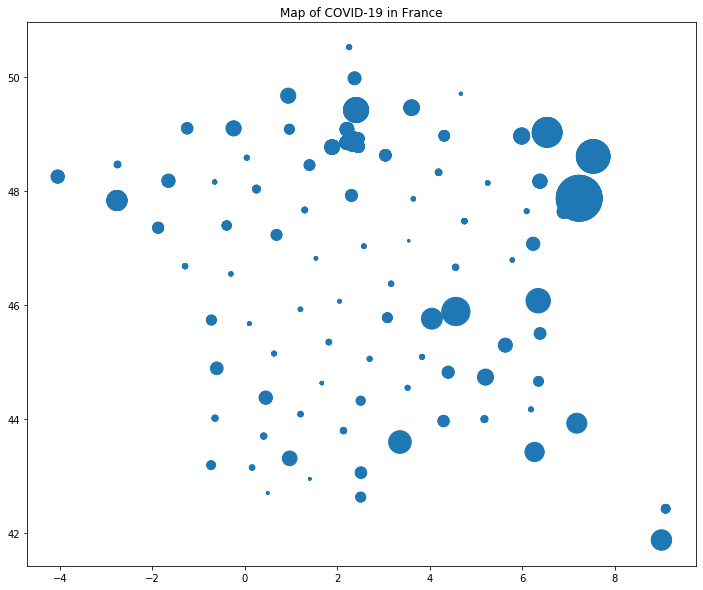

In [481]:
plt.figure(figsize=(12,10))
plt.scatter(df_dep['longitude'], df_dep['latitude'], s=df_dep['cas_confirmes']*3)
plt.title("Map of COVID-19 in France")
plt.show()

## 2. Plots with background with Cartopy

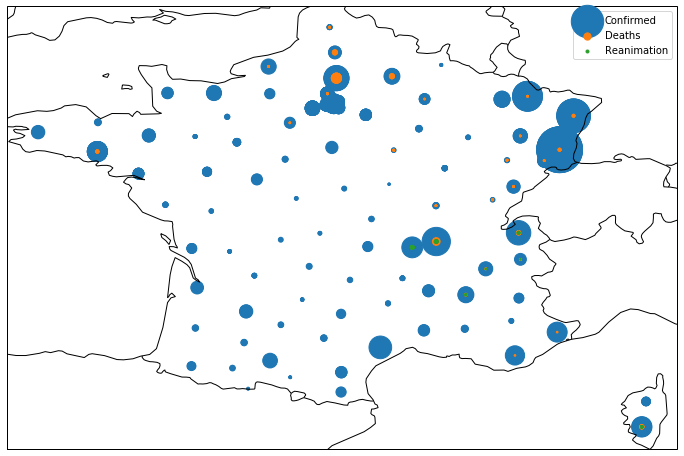

In [482]:
fig = plt.figure(figsize=(12,10))

# Select projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data
plt.scatter(df_dep['longitude'], df_dep['latitude'], s=df_dep['cas_confirmes']*3, label="Confirmed") 
plt.scatter(df_dep['longitude'], df_dep['latitude'], s=df_dep['deces']*3, label="Deaths") 
plt.scatter(df_dep['longitude'], df_dep['latitude'], s=df_dep['reanimation']*3, label="Reanimation") 

# Add coastlines and borders
ax.coastlines(resolution='50m', linewidth=1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
plt.legend()

plt.show()

## 3. Plot using Bokeh

In [483]:
shapefile = 'ne_110m_admin_0_countries.shp'

#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]

In [484]:
#Rename columns.
gdf.columns = ['country', 'country_code', 'geometry']
gdf.head()

,country,country_code,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [485]:
gdf = gdf[gdf['country']=="France"]
# Keep Only continental France and Corsica
gdf['geometry'][43] = wkt.loads('MULTIPOLYGON (((6.186320428094177 49.46380280211451, 6.658229607783568 49.20195831969157, 8.099278598674744 49.01778351500333, 7.593676385131062 48.33301911070372, 7.466759067422231 47.62058197691181, 7.192202182655507 47.44976552997102, 6.736571079138059 47.54180125588285, 6.768713820023606 47.2877082383037, 6.037388950229001 46.72577871356187, 6.022609490593538 46.27298981382047, 6.500099724970426 46.42967275652944, 6.843592970414505 45.99114655210061, 6.802355177445605 45.70857982032864, 7.096652459347837 45.33309886329589, 6.749955275101655 45.02851797136758, 7.007562290076635 44.25476675066136, 7.549596388386107 44.12790110938481, 7.435184767291872 43.69384491634922, 6.52924523278304 43.12889232031831, 4.556962517931424 43.3996509873116, 3.100410597352663 43.07520050716705, 2.985998976258458 42.47301504166986, 1.826793247087153 42.34338471126569, 0.7015906103638941 42.79573436133261, 0.3380469091905809 42.57954600683955, -1.502770961910528 43.03401439063043, -1.901351284177764 43.42280202897834, -1.384225226232985 44.02261037859012, -1.193797573237418 46.01491771095486, -2.225724249673846 47.06436269793822, -2.963276129559603 47.57032664650795, -4.491554938159481 47.95495433205637, -4.592349819344776 48.68416046812699, -3.295813971357802 48.90169240985963, -1.616510789384961 48.64442129169454, -1.933494025063311 49.77634186461574, -0.98946895995536 49.34737580016091, 1.338761020522696 50.12717316344526, 1.6390010921385 50.9466063502975, 2.513573032246143 51.14850617126183, 2.658422071960274 50.79684804951575, 3.123251580425688 50.78036326761455, 3.588184441755658 50.37899241800356, 4.286022983425084 49.90749664977255, 4.799221632515724 49.98537303323637, 5.674051954784829 49.5294835475575, 5.897759230176348 49.44266714130711, 6.186320428094177 49.46380280211451)), ((6.186320428094177 49.46380280211451, 6.658229607783568 49.20195831969157, 8.099278598674744 49.01778351500333, 7.593676385131062 48.33301911070372, 7.466759067422231 47.62058197691181, 7.192202182655507 47.44976552997102, 6.736571079138059 47.54180125588285, 6.768713820023606 47.2877082383037, 6.037388950229001 46.72577871356187, 6.022609490593538 46.27298981382047, 6.500099724970426 46.42967275652944, 6.843592970414505 45.99114655210061, 6.802355177445605 45.70857982032864, 7.096652459347837 45.33309886329589, 6.749955275101655 45.02851797136758, 7.007562290076635 44.25476675066136, 7.549596388386107 44.12790110938481, 7.435184767291872 43.69384491634922, 6.52924523278304 43.12889232031831, 4.556962517931424 43.3996509873116, 3.100410597352663 43.07520050716705, 2.985998976258458 42.47301504166986, 1.826793247087153 42.34338471126569, 0.7015906103638941 42.79573436133261, 0.3380469091905809 42.57954600683955, -1.502770961910528 43.03401439063043, -1.901351284177764 43.42280202897834, -1.384225226232985 44.02261037859012, -1.193797573237418 46.01491771095486, -2.225724249673846 47.06436269793822, -2.963276129559603 47.57032664650795, -4.491554938159481 47.95495433205637, -4.592349819344776 48.68416046812699, -3.295813971357802 48.90169240985963, -1.616510789384961 48.64442129169454, -1.933494025063311 49.77634186461574, -0.98946895995536 49.34737580016091, 1.338761020522696 50.12717316344526, 1.6390010921385 50.9466063502975, 2.513573032246143 51.14850617126183, 2.658422071960274 50.79684804951575, 3.123251580425688 50.78036326761455, 3.588184441755658 50.37899241800356, 4.286022983425084 49.90749664977255, 4.799221632515724 49.98537303323637, 5.674051954784829 49.5294835475575, 5.897759230176348 49.44266714130711, 6.186320428094177 49.46380280211451)), ((8.746009148807559 42.62812185319392, 9.390000848028876 43.00998484961471, 9.560016310269134 42.15249197037952, 9.229752231491773 41.38000682226446, 8.775723097375362 41.58361196549443, 8.544212680707773 42.25651662858306, 8.746009148807559 42.62812185319392)))')

In [486]:
grid_crs=gdf.crs

#Read data to json.
gdf_json = json.loads(gdf.to_json())
#Convert to String like object.
grid = json.dumps(gdf_json)

This code was taken from [here](https://github.com/CrazyDaffodils/Interactive-Choropleth-Map-Using-Python/blob/master/bokeh-app/coronavirus_geocode_csv.ipynb).

In [490]:
df_dep_today = df_dep[df_dep['date'] == '2020-03-19']
df_dep_today['size'] = df_dep_today['cas_confirmes']/5

/Users/maelfabien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [491]:
df_dep_today

,date,granularite,maille_code,maille_nom,cas_confirmes,deces,reanimation,latitude,longitude,size
1320,2020-03-19,departement,DEP-01,Ain,84.0,5.0,0.0,49.453285,3.606899,16.8
5691,2020-03-19,departement,DEP-02,Aisne,0.0,9.0,0.0,49.453285,3.606899,0.0
1321,2020-03-19,departement,DEP-03,Allier,10.0,0.0,0.0,46.367464,3.163883,2.0
1322,2020-03-19,departement,DEP-04,Alpes-de-Haute-Provence,8.0,0.0,0.0,44.164083,6.187852,1.6
1323,2020-03-19,departement,DEP-05,Hautes-Alpes,31.0,0.0,0.0,44.656467,6.352025,6.2
...,...,...,...,...,...,...,...,...,...,...
5721,2020-03-19,departement,DEP-90,Territoire de Belfort,0.0,1.0,0.0,47.629231,6.899301,0.0
5723,2020-03-19,departement,DEP-92,Hauts-de-Seine,59.0,0.0,0.0,48.840186,2.198641,11.8
5724,2020-03-19,departement,DEP-93,Seine-Saint-Denis,45.0,0.0,0.0,48.909813,2.452863,9.0
5725,2020-03-19,departement,DEP-94,Val-de-Marne,48.0,0.0,0.0,48.774489,2.454332,9.6


In [492]:
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = grid)
pointsource = ColumnDataSource(df_dep_today)

hover = HoverTool(
    tooltips = [('Place', '@maille_nom'), ('Confirmed cases','@cas_confirmes'),('Deaths','@deces'), ('Reanimation','@reanimation'), ('URL', '@source_url')]
)

#Create figure object.
p = figure(title = 'Geographic distribution of 2019-nCov cases in France', plot_height = 600 , plot_width = 950, tools=[hover, 'pan', 'wheel_zoom'])
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

patch=p.patches('xs','ys', source = geosource,fill_color = '#fff7bc',
          line_color = 'black', line_width = 0.35, fill_alpha = 1, 
                hover_fill_color="#fec44f")

#Add patch renderer to figure. 
patch = p.patches('xs','ys', source = geosource,fill_color = 'lightgrey',
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

#p.add_tools(HoverTool(tooltips=[('Confirmed cases','@cas_confirmes'),('Deaths','@deces'), ('Reanimation','@reanimation')], renderers=[patch]))

p.circle('longitude','latitude',source=pointsource, size='size')
#Display figure inline in Jupyter Notebook.

output_notebook()
#Display figure.
show(p)

Loading BokehJS ...